# How much danger am I in?

Ever wondered just how much danger you're in when you go out at night? In our project, we want to investigate whether we can predict the danger posed to an individual depending on the time of day, day of week, month, temperature, and weather. 

### Outline
We work with a crime and 2 weather dataset over the past 3 years (FBI: UCR,Weather Underground API), and a variety of libaries including [matplolib](http://matplotlib.org/), [scipy](http://www.scipy.org/), [statsmodels](http://statsmodels.sourceforge.net/), and standard packages [pandas](http://pandas.pydata.org/) and [numpy](http://www.numpy.org/).

We set to estimate crime frequency given a set of predictors. We will begin by examining the data to decide which variables we wish to model. After this we will build a linear regression in the hopes of predicting the estimated crime frequency. Finally, we will perform diagnostics and decide ways we can improve our model.

We will cover the following topics in this tutorial:
- [Data Extraction](#Data Extraction)
- [Exploratory Data Analysis](#Exploratory Data Analysis)
- [Building Regression Dataset](#Building Regression Dataset)
- [Building Linear Regression Model](#Building Linear Regression Model)
- [Diagnostics](#Diagnostics)
- [Perfecting The Model](#Perfecting The Model)

In [240]:
#$ pip install pyowm
import pandas as pd
import datetime as dt
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as sc
import scipy.linalg as la
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import seaborn # or alternatively plt.style.use('ggplot') for a similar look

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

## Data Extraction

We begin by first importing the necessary data and stastical packages that we will use to help predict crime frequency, as shown above. Afterwards, we import the crime and weather data, and once we have done so we merge the two into a dataset we will begin working with for exploratory data analysis.

In [194]:
#Import crime data
crime_data = pd.read_csv('crime_reports.csv')

#Import weather data
weather2015 = pd.read_csv('weather_2015.csv', parse_dates = True)
weather2016 = pd.read_csv('weather_2016.csv', parse_dates = True)
    
print crime_data.shape[0]
frames = [weather2015,weather2016]
weather  = pd.concat(frames)

weather['EST'] = pd.to_datetime(weather['EST'], format='%m/%d/%Y')
crime_data['ARREST_TIME'] = pd.to_datetime(crime_data['ARREST_TIME'])
crime_data['EST'] = pd.DatetimeIndex(crime_data.ARREST_TIME).normalize()

#Combine temperature and date
data = pd.merge(crime_data, weather, how = 'left', left_on = 'EST',right_on = 'EST')

118835


The columns and datatypes we will be working with include:

```python
_id                                    int64
REPORT_NAME                           object
CCR                                    int64
SECTION                               object
DESCRIPTION                           object
ARREST_TIME                   datetime64[ns]
ADDRESS                               object
NEIGHBORHOOD                          object
ZONE                                 float64
AGE                                  float64
GENDER                                object
EST                           datetime64[ns]
Max TemperatureF                       int64
Mean TemperatureF                      int64
Min TemperatureF                       int64
Max Dew PointF                         int64
MeanDew PointF                         int64
Min DewpointF                          int64
Max Humidity                           int64
 Mean Humidity                         int64
 Min Humidity                          int64
 Max Sea Level PressureIn            float64
 Mean Sea Level PressureIn           float64
 Min Sea Level PressureIn            float64
 Max VisibilityMiles                   int64
 Mean VisibilityMiles                  int64
 Min VisibilityMiles                   int64
 Max Wind SpeedMPH                     int64
 Mean Wind SpeedMPH                    int64
 Max Gust SpeedMPH                   float64
PrecipitationIn                      float64
 CloudCover                            int64
 Events                               object
 WindDirDegrees                        int64
dtype: object
```

```python
   _id  REPORT_NAME       CCR SECTION          DESCRIPTION  \
0  53078  OFFENSE 2.0  15154929    3502            Burglary.   
1  53079  OFFENSE 2.0  15155179    3502            Burglary.   
2  53080  OFFENSE 2.0  15161163    9124   Drug Investigation   
3  53081  OFFENSE 2.0  15155881    4106  Access Device Fraud   
4  53082  OFFENSE 2.0  15155881    3502            Burglary.   

          ARREST_TIME                     ADDRESS      NEIGHBORHOOD  ZONE  \
0 2015-08-18 06:13:00  700 block E Warrington Ave         Allentown   3.0   
1 2015-08-18 07:45:00      2500 block E Carson St  South Side Flats   3.0   
2 2015-08-26 18:15:00                      Zone 1  Brighton Heights   1.0   
3 2015-08-18 10:00:00         400 block Ruxton St  Mount Washington   3.0   
4 2015-08-18 10:00:00         400 block Ruxton St  Mount Washington   3.0   

   AGE       ...         Max VisibilityMiles  Mean VisibilityMiles  \
0  NaN       ...                          10                     8   
1  NaN       ...                          10                     8   
2  NaN       ...                          10                    10   
3  NaN       ...                          10                     8   
4  NaN       ...                          10                     8   

    Min VisibilityMiles   Max Wind SpeedMPH   Mean Wind SpeedMPH  \
0                     1                  21                    7   
1                     1                  21                    7   
2                    10                   8                    6   
3                     1                  21                    7   
4                     1                  21                    7   

    Max Gust SpeedMPH  PrecipitationIn   CloudCover   Events   WindDirDegrees  
0                26.0             1.09            6     Rain              177  
1                26.0             1.09            6     Rain              177  
2                 NaN             0.00            5      NaN              277  
3                26.0             1.09            6     Rain              177  
4                26.0             1.09            6     Rain              177  
```

## Exploratory Data Analysis

We now wish to perform EDA on our crime dataset. We will examine a few key predictors; time of day (hours), day of the week (weekday), month, mean temperature (farenheit), and weather (categorical 'events'). First, let's see if there is a correlation between temperature and crime. 

In [199]:
grouped = data.groupby('Mean TemperatureF').agg(['mean', 'count'])
print grouped

                             _id             CCR            ZONE        \
                            mean count      mean count      mean count   
Mean TemperatureF                                                        
10                   1952.845000   200  15888622   200  2.879397   199   
11                   7170.121622   148  15994901   148  3.959459   148   
12                   3433.440000   450  15957756   450  3.006667   450   
14                   6861.838509   161  15969422   161  3.273292   161   
15                   3125.955975   159  15996711   159  3.402516   159   
16                   6710.814286   140  15858889   140  3.100000   140   
18                  81254.423913   184  15794900   184  3.417582   182   
19                   2855.321429   196  15940696   196  3.750000   196   
20                   2576.115385   468  15935066   468  3.242489   466   
21                  16416.701923   312  15382508   312  3.397436   312   
22                  35866.382271   361

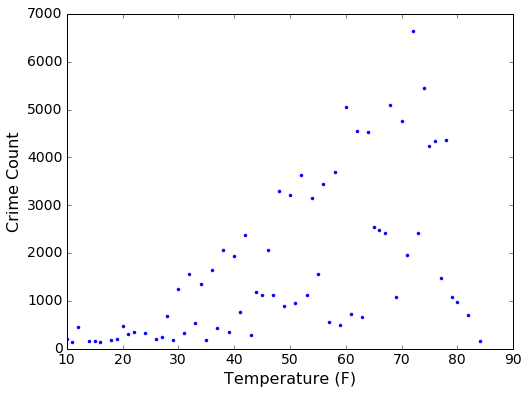

In [200]:
x = grouped.index
y = grouped._id.loc[:,'count'].values
plt.plot(x,y,'.')
plt.xlabel('Temperature (F)')
plt.ylabel('Crime Count')

We will use the Pearson product-moment correlation coefficient to measure the linear dependence between X and Y. 

In [201]:
print sc.pearsonr(x,y)

(0.58786924163197674, 1.0908233638972888e-07)


Given our small sample size of only 1-2 years worth of data, a pearson coefficient of 0.59 tells us there is a relatively strong linear correlation between temperature and crime. It is more likely for violent crime to occur when the temperature is warmer.

Next, let's look at the four other variables we mentioned. For weather we will simply map the 10 possible "weather events" into an integer value. The time based data will be treated as cyclical variables using the formula;

$time = \sin\left(2\pi \frac{f}{N}\right)$

In [202]:
data.set_index('ARREST_TIME', inplace=True)

In [213]:
# Mapping time data to be cyclic
data['time'] = np.sin(2*np.pi*(data.index.hour * 60 + data.index.minute / float(60*24)))
data['day'] = np.sin(2*np.pi*data.index.weekday / float(7))
data['season'] = np.sin(2*np.pi*data.index.month / float(12))

# Mapping weather to be numeric
D = {}
weather = np.unique(data[' Events'])
for i in xrange(0,len(weather)):
    D[weather[i]] = i
data['weather'] = data[' Events'].apply(lambda x: D[x])

Now we can group the data as we did before and examine the relationship each of these predictors have with crime frequency.

Crime appears to drastically uptick near midnight and midday, in the middle of the week and gradually increases on the weekends, and  that the late summer months have the greatest frequency of crime, and that crime tends to only happen when the weather is clear or it's raining (encoding of 0 and 6 respectively).

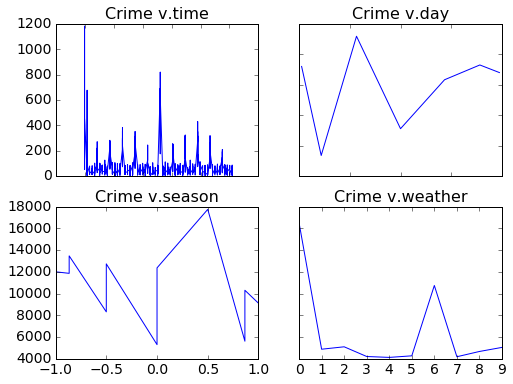

In [211]:
# Subplot variables
f, axarr = plt.subplots(2, 2)
preds = ['time','day','season','weather']
for i in xrange(0,4):
    grouped = data.groupby(preds[i]).agg(['count'])
    x = grouped.index
    y = grouped._id.loc[:,'count'].values
    axarr[i/2, i%2].plot(x, y)
    axarr[i/2, i%2].set_title("Crime v." + preds[i])
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
a =plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

## Building Regression Dataset

We can now build our dataset for our regression model. Our dataset has a lot of variables we do not need, so we will begin by creating a new dataset using the 5 variables mentioned above.

Currently our dataset only has the observed crimes. We will change this to include a predictor, $Y$, the frequency of crimes grouped by predictors.

In [226]:
newData = pd.concat([data['time'], data['day'], data['season'], data['weather'], data['Mean TemperatureF'], data['_id']], axis=1)
groupedCrime = newData.groupby(['day','time','weather', 'season','Mean TemperatureF']).agg(['count'])
groupedCrime

_id
                                                                count
day       time          weather season        Mean TemperatureF      
-0.974928 -1.175958e-12 0       -1.000000e+00 65                    1
                                              66                    2
                                              67                    1
                                              72                    1
                                -8.660254e-01 51                    2
                                              68                    6
                                              72                    1
                                -5.000000e-01 48                    1
                                              72                    3
                                              73                    1
                                              75                    1
                                -2.449294e-16 62                    2
                                 1.224647e-16 75                    8
                                              78                    1
                                 5.000000e-01 38                    2
                                              56                    1
                                              76                    1
                                 1.000000e+00 52                    1
                        1       -2.449294e-16 38                    5
                                 1.224647e-16 67                    1
                        2       -5.000000e-01 71                    2
                        6       -1.000000e+00 71                    1
                                -8.660254e-01 47                    2
                                -5.000000e-01 45                    1
                                              52                    1
                                -2.449294e-16 52                    1
                                 1.224647e-16 70                    1
                                 5.000000e-01 58                    1
                        9        1.000000e+00 21                    1
                                              36                    2
...                                                               ...
 0.974928  2.546019e-01 6       -5.000000e-01 68                    1
                                -8.660254e-01 70                    1
                                -5.000000e-01 68                    1
                        0       -1.000000e+00 68                    1
                                -5.000000e-01 65                    1
                        6       -5.000000e-01 59                    2
                        0       -1.000000e+00 68                    2
                                -5.000000e-01 80                    6
                                 1.224647e-16 71                    2
                        6       -8.660254e-01 70                    1
                                 1.224647e-16 58                   14
                                 5.000000e-01 72                    3
                        0       -1.000000e+00 65                    6
                                -5.000000e-01 80                    1
                        6       -8.660254e-01 82                    3
                        0        1.224647e-16 74                    2
                        6        8.660254e-01 43                    1
                        0        1.224647e-16 74                    5
                                 1.000000e+00 62                    1
                                -8.660254e-01 73                    2
                                -2.449294e-16 46                    3
                                 5.000000e-01 52                    1
                                 1.000000e+00 60                    6
                        6       -1.000000e+00 60                    1
      

With a response variable we can now convert this back to a dataframe that we can work with our regression model.

In [235]:
Y = groupedCrime._id.loc[:,'count'].values
nX = np.zeros((len(Y),5))
for i in xrange(0,len(Y)):
    nX[i] = np.array(groupedCrime.iloc[i].name)
print nX.shape, Y
X = pd.DataFrame(data=X,columns=['Day','Time','Weather', 'Season','Temp','Crime'])
X.Crime = Y
X

(54775L, 5L) [1 2 1 ..., 9 1 1]


,Day,Time,Weather,Season,Temp,Crime
0,-0.974928,-1.175958e-12,0.0,-1.000000e+00,65.0,1
1,-0.974928,-1.175958e-12,0.0,-1.000000e+00,66.0,2
2,-0.974928,-1.175958e-12,0.0,-1.000000e+00,67.0,1
3,-0.974928,-1.175958e-12,0.0,-1.000000e+00,72.0,1
4,-0.974928,-1.175958e-12,0.0,-8.660254e-01,51.0,2
5,-0.974928,-1.175958e-12,0.0,-8.660254e-01,68.0,6
6,-0.974928,-1.175958e-12,0.0,-8.660254e-01,72.0,1
7,-0.974928,-1.175958e-12,0.0,-5.000000e-01,48.0,1
8,-0.974928,-1.175958e-12,0.0,-5.000000e-01,72.0,3
9,-0.974928,-1.175958e-12,0.0,-5.000000e-01,73.0,1


## Building Linear Regression Model

We can now begin building our model. We will be using linear regression and working with the statsmodel library.

In [238]:
# Build Linear Regression Model
reg = smf.ols('Crime ~ Day + Time + Weather + Season + Temp', data=X).fit()
print (reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.01
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           9.20e-15
Time:                        22:43:30   Log-Likelihood:            -1.2301e+05
No. Observations:               54775   AIC:                         2.460e+05
Df Residuals:                   54769   BIC:                         2.461e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0816      0.048     43.114      0.0

This summary tells us that the overall model appears to be correct with a signifiantly low model p-value and that temperature appeara to be significant and has a positive relationship with crime frequency.

However, variables such as Day and Season do not appear to be significant and so we may remove these variables or turn them into indicator variables.

## Diagnostics

Let's examine if our assumptions about a linear model hold, (i.e. the residuals are normally distributed and linear). We will do this using a Q-Q Plot and simple regresion plot.

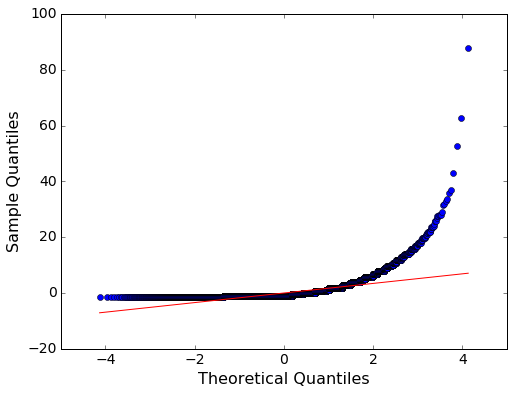

In [246]:
#Q-Q plot for normality
fig1=sm.qqplot(reg.resid, line='r')

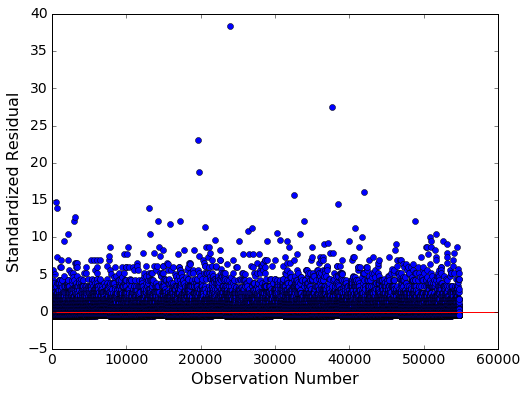

In [245]:
# simple plot of residuals
stdres=pd.DataFrame(reg.resid_pearson)
fig2 = plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

The residuals diverge away from the normal regression line, indicating skewness...


(array([  4.15790000e+04,   7.99200000e+03,   2.76100000e+03,
          1.20900000e+03,   2.45000000e+02,   4.26000000e+02,
          2.42000000e+02,   1.20000000e+02,   8.10000000e+01,
          2.90000000e+01,   3.20000000e+01,   1.80000000e+01,
          1.30000000e+01,   2.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

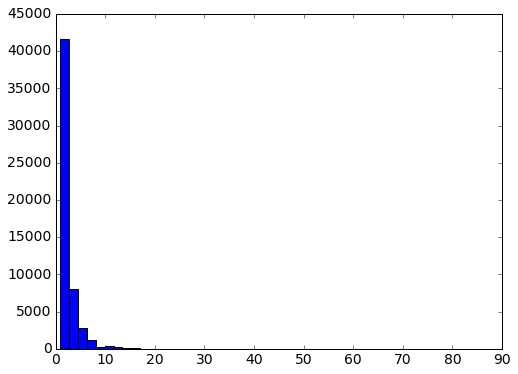

In [248]:
plt.hist(Y,bins=50)

## Perfecting The Model

...